# Living Polymerization – Chain Length Distribution

## Theory

A living polymerization is a type of chain-growth polymerization in which the number of polymer chains remains constant. In practice, this means that the only reactions considered are initiation and propagation, while termination and transfer reactions are negligible. Assuming that both the initiation and propagation steps are first-order with respect to the monomer and the active center, the transient balances are as follows:

\begin{align*}
\frac{\textrm{d}[I]}{\textrm{d}t}   & = - k_i [I] [M] \\
\frac{\textrm{d}[P_1]}{\textrm{d}t} & = + (k_i [I] - k_p [P_1]) [M] \\
\frac{\textrm{d}[P_n]}{\textrm{d}t} & = + k_p ([P_{n-1}] - [P_{n-1}]) [M], \;n \ge 2 \\
\frac{\textrm{d}[M]}{\textrm{d}t}   & = - (k_i [I] + k_p \sum_{k=1}^\infty [P_k] )[M]
\end{align*}

By defining an appropriate upper limit for the chain length $N$, we obtain a closed set of $N+2$ ordinary differential equations (ODEs), which can be easily integrated.


If our focus is solely on the chain-length distribution (CLD) and not on the time evolution of species concentrations, we can define the ratio $r=k_p/k_i$. Dividing the first three balance equations by $\textrm{d}[M]/\textrm{d}t$ eliminates $t$, yielding the following:

\begin{align*}
\frac{\textrm{d}[I]}{\textrm{d}[M]}   & = + \frac{[I]}{[I] + r \sum_k [P_k]} \\
\frac{\textrm{d}[P_1]}{\textrm{d}[M]} & = - \frac{[I] - r [P_1]}{[I] + r\sum_k [P_k]} \\
\frac{\textrm{d}[P_n]}{\textrm{d}[M]} & = - r \frac{[P_{n-1}] - [P_n]}{[I] + r \sum_k [P_k]}
\end{align*}

The number-average chain length of the full distribution (considering initiator molecules as chains of length 0) is:

\begin{align*}
v = \frac{[M]_0 - [M]}{[I]_0}
\end{align*}

and the number fractions of each kind of chain are:

\begin{align*}
p_0 & = \frac{[I]}{[I]_0} \\
p_n & = \frac{[P_n]}{[I]_0}, \;n \ge 1
\end{align*}

where, by construction, $\sum_{k=0}^{\infty} p_k = 1$. Noting that $\textrm{d}[M] = - [I]_0 \textrm{d}v$, we can finally write:

\begin{align*}
\frac{\textrm{d} p_0}{\textrm{d} v} & = - \frac{p_0}{p_0 + r \sum_k p_k} \\
\frac{\textrm{d} p_1}{\textrm{d} v} & = \frac{p_0 - r p_1}{p_0 + r \sum_k p_k} \\
\frac{\textrm{d} p_n}{\textrm{d} v} & = r \frac{p_{n-1} - p_n}{p_0 + r \sum_k p_k}
\end{align*}

which forms a closed set of $N+1$ ODEs, which can be solved analytically, leading to the so-called [Weibull-Nycander-Gold] distribution.

[Weibull-Nycander-Gold]: https://hugomvale.github.io/polykin/reference/distributions/WeibullNycanderGold_pdf/#polykin.distributions.analyticaldistributions.WeibullNycanderGold_pdf


## Numerical Solution

Let us implement a method to numerically evaluate $p_k$ as a function of the parameters $v$ and $r$.


In [6]:
# If running in Google Colab, uncomment lines below
# %pip install ipywidgets
# from google.colab import output
# output.enable_custom_widget_manager()

In [7]:
%matplotlib widget
import ipywidgets as widgets
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import functools

First, we write a function to compute the time derivative of the ODE system, i.e. $\dot{y}(t, y)$.

In [8]:
def ydot(t: float, y: np.ndarray, v: float, r: float) -> np.ndarray:
    "Derivative of the state vector, dy/dt."
    p = y
    pdot = np.empty_like(p)
    pdot[0] = -p[0]
    pdot[1] = p[0] - r*p[1]
    pdot[2:] = r*(p[1:-1] - p[2:])
    pdot /= p[0] + r*p[1:].sum()
    return pdot

Then, we perform the numerical integration using a suitable ODE solver. This system is non-stiff (do you know why?), therefore we can use an explicit scheme.

In [9]:
@functools.cache
def compute_distribution(v: float, r: float) -> np.ndarray:

    # Upper bound of the chain length
    N = np.max([10, 4*int(v)]) + 1

    # Initial condition
    p0 = np.zeros(N)
    p0[0] = 1.

    # Solve ODE set
    solution = solve_ivp(ydot,
                         t_span=(0, v),
                         y0=p0,
                         args=(v, r),
                         method='RK45', # non-stiff ODEs
                         rtol=1e-5,
                         atol=1e-6
                         )
    
    # Final distribution
    p = solution.y[:, -1]

    return p

Now, let's make an (efficient) interactive plot.

interactive(children=(FloatSlider(value=1.0, continuous_update=False, description='v', min=1.0, step=1.0), Flo…

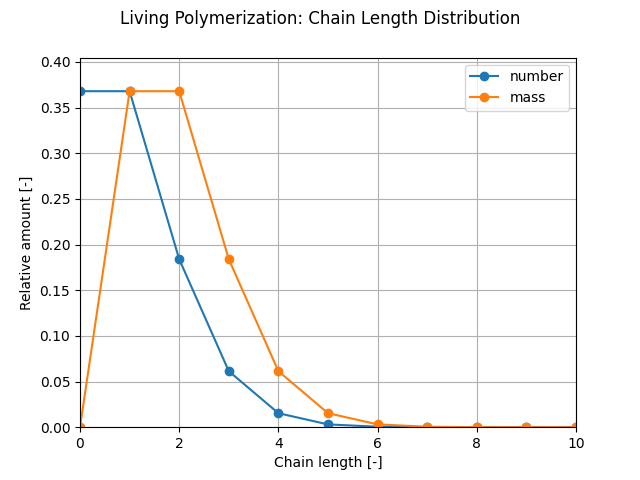

In [10]:
# Create the figure
fig, ax = plt.subplots()
fig.suptitle("Living Polymerization: Chain Length Distribution")
fig.canvas.header_visible = False

# Add empty lines (to be updated)
line_number, = ax.plot([], [], "o-", label="number")
line_mass, =  ax.plot([], [], "o-", label="mass")

ax.set_xlabel("Chain length [-]")
ax.set_ylabel("Relative amount [-]")
ax.grid(True)
ax.legend(loc="upper right")

# Update the lines with distribution results
def update_plot(v: float, r: float):

    # Number distribution
    p = compute_distribution(v, r)

    # Chains lengths
    s = np.arange(0, p.size)

    # Weight distribution
    w = s*p
    w /= w.sum()

    # Update the plot
    line_number.set_data(s, p)
    line_mass.set_data(s, w)
    ax.set_xlim(s[0], s[-1])
    ax.set_ylim(0., 1.1*np.max((np.max(p), np.max(w))))
    fig.canvas.draw()


res = widgets.interact(update_plot,
                 v=widgets.FloatSlider(
                     value=1.,
                     min=1.,
                     max=100.,
                     step=1.,
                     continuous_update=False),
                 r=widgets.FloatLogSlider(
                     value=1.,
                     min=-1.,
                     max=2.,
                     step=0.2,
                     continuous_update=False)
                     )